<a href="https://colab.research.google.com/github/hardikgw/neural-network-poc/blob/master/notebooks/NNKeras_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install matplotlib

In [0]:
import time
import numpy as np
import pandas as pd
from keras.callbacks import TensorBoard
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.callbacks import Callback
from itertools import groupby
from statistics import mean
import matplotlib.pyplot as plt
from datetime import timedelta
from IPython.display import clear_output

In [0]:
def plot_training_summary(training_summary, time_summary=None):
    if time_summary:
        print('Training time: ' + str(timedelta(seconds=time_summary.training_time)))
        print('Epoch time avg: '  + str(timedelta(seconds=mean(time_summary.epoch_times))))
    hist = sorted(training_summary.history.items(),
                  key=lambda x: (x[0].replace('val_', ''), x[0]))

    epochs = [e + 1 for e in training_summary.epoch]
    for metric, values in groupby(hist,
                                  key=lambda x: x[0].replace('val_', '')):
        if 'val_loss' in training_summary.history:
            val0, val1 = tuple(values)
            plt.plot(epochs, val0[1], epochs, val1[1], '--', marker='o')
        else:
            val0 = tuple(values)[0]
            plt.plot(epochs, val0[1], '--', marker='o')
        plt.xlabel('epoch'), plt.ylabel(val0[0])
        plt.legend(('Train set', 'Validation set'))
        plt.show()

In [0]:
class TrainingPlot(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        if len(self.losses) > 1:
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            plt.style.use("seaborn")
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

In [0]:
class TimeSummary(Callback):
    def on_train_begin(self, logs={}):
        self.epoch_times = []
        self.training_time = time.process_time()

    def on_train_end(self, logs={}):
        self.training_time = time.process_time() - self.training_time

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.process_time()

    def on_epoch_end(self, batch, logs={}):
        self.epoch_times.append(time.process_time() - self.epoch_time_start)

In [0]:
class NNKeras:
    def __init__(self, url: str):
        self._url = url
        self._num_cols = 64
        self._call_back = TensorBoard(log_dir='../logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

    def read_data(self):
        df = pd.read_csv(self._url, header=None)
        X = df.iloc[:, 1:].astype(float)
        classes = df.iloc[:, 0]
        unique_classes = pd.DataFrame(sorted([c.upper() for c in classes.unique()]))
        rows = X.shape[0]
        unique_classes['indices'] = range(1, len(unique_classes) + 1)
        y = np.zeros((rows, len(unique_classes)), np.bool)
        for i in range(rows):
            col_idx = np.where(unique_classes.loc[:, 0] == classes[i].upper())
            y[i, col_idx] = True
        return X, y, unique_classes

    def base_model(self, nodes):
        model = Sequential()

        for prev_node, node in zip(nodes[:-1], nodes[1:]):
            model.add(Dense(node, activation='relu', input_dim=prev_node))  # Add the first hidden layer

        model.add(Dense(31, activation='sigmoid'))  # Add the output layer
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def train(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=5)
        time_summary = TimeSummary()
        for num_nodes in range(2, 100):
            nodes = [64, num_nodes]
            model = self.base_model(nodes)
            summary = model.fit(X_train, y_train, epochs=10, verbose=0, callbacks=[self._call_back,time_summary,plot_losses])
            score = model.evaluate(X_test, y_test)
            plot_training_summary(summary, time_summary)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

In [0]:
nn = NNKeras("https://raw.githubusercontent.com/hardikgw/neural-network-poc/master/data/dataset/dataset.csv")
#nn = NNKeras("/tf/dataset/dataset.csv")

In [0]:
X, y, unique_classes = nn.read_data()

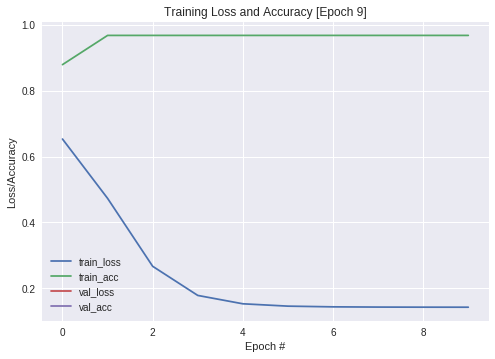

157/157 [==============================] - 3s 19ms/step
Training time: 0:00:08.439784
Epoch time avg: 0:00:00.397236


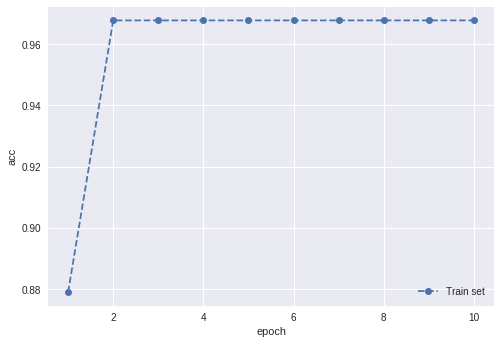

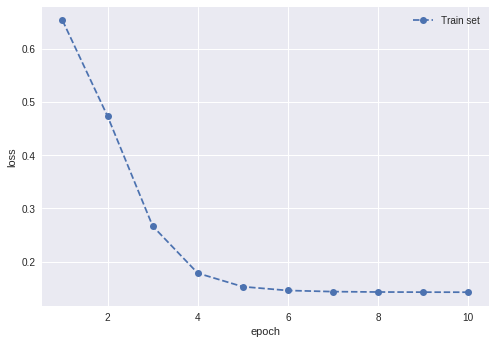

Test loss: 0.14259430054266742
Test accuracy: 0.9677418956331386


In [0]:
nn.train(X, y)